<a href="https://colab.research.google.com/github/tobyzawthuhtet/built-up-area-detection-using-deep-learning/blob/main/Built_Up_Area_classification_using_Sentinel_1_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing mendatory libaries


In [1]:
!pip install pyrsgis

# Importing Libraries

In [16]:
import os
import numpy as np
from tensorflow import keras
from pyrsgis import raster
from pyrsgis.convert import changeDimension
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import tensorflow as tf

import glob

# Changing Directory to load data

In [17]:
ls

label.tif              sample_data/       yangon_train.tif
new_s1_median_mdy.tif  training_data.tif  Ygn_label.tif


In [18]:
data = glob.glob("*.tif")
for i in data:
  print(i)

training_data.tif
label.tif
Ygn_label.tif
yangon_train.tif
new_s1_median_mdy.tif


In [21]:
mxTraining = 'yangon_train.tif' #Assigning Training Data
builtupTraining = 'Ygn_label.tif'    #Assigning Label Data 
mxTesting = 'new_s1_median_mdy.tif'    #Assigning Inferencing Data


Reading bands from imageries

In [22]:
ds1, featuresTrain = raster.read(mxTraining, bands='all')
ds2, labelTrain = raster.read(builtupTraining, bands=1)
ds3, featuresTest = raster.read(mxTesting, bands='all')



In [23]:
print("Train Multispectral image shape: ", featuresTrain.shape)
print("Train Binary built-up image shape: ", labelTrain.shape)
print("Test Multispectral image shape: ", featuresTest.shape)


Train Multispectral image shape:  (2, 1250, 1596)
Train Binary built-up image shape:  (1250, 1596)
Test Multispectral image shape:  (2, 883, 831)


# Data Visualization

Text(0.5, 1.0, 'Yangon Built Up Label')

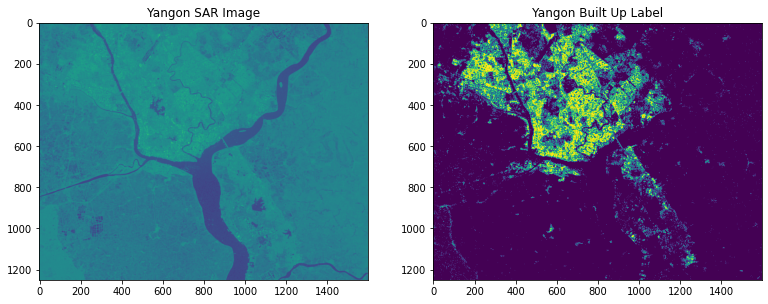

In [35]:
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow(featuresTrain[1])
plt.title('Yangon SAR Image')
plt.subplot(332)
plt.imshow(labelTrain)
plt.title('Yangon Built Up Label')



## Label data is reclasify again 

In [36]:
labelTrain = (labelTrain == 1).astype(int) #Reclassifying Data 

In [37]:
print("Training Multispectral image shape: ", featuresTrain.shape)
print("Training Binary built-up image shape: ", labelTrain.shape)
print("Testing Multispectral image shape: ", featuresTest.shape)


Training Multispectral image shape:  (2, 1250, 1596)
Training Binary built-up image shape:  (1250, 1596)
Testing Multispectral image shape:  (2, 883, 831)


# changDimension modules from Pyrsgis is used here to change into 1 Dimensional array

In [38]:
featuresTrain = changeDimension(featuresTrain) # Changing Dimension
labelTrain = changeDimension (labelTrain)
featuresTest = changeDimension(featuresTest)
nBands = featuresTrain.shape[1]

## Splitting into training data and testing data

In [39]:
xTrain, xTest, yTrain, yTest = train_test_split(featuresTrain, labelTrain, test_size=0.4, random_state=42)


In [40]:
print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(1197000, 2)
(1197000,)
(798000, 2)
(798000,)


# Training data and testing data are normalized here for better training

In [41]:
xTrain = xTrain / 255.0
xTest = xTest / 255.0
featuresTest = featuresTest / 255.0


In [42]:
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))


In [43]:
featuresTest = featuresTest.reshape((featuresTest.shape[0], 1, featuresTest.shape[1]))


In [44]:
print(xTrain.shape, xTest.shape,featuresTest.shape)


(1197000, 1, 2) (798000, 1, 2) (733773, 1, 2)


# Tensorflow Model

In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs['loss'] <= 0.01):
            print('\nLoss has reached 0.01')
            self.model.stop_training = True

cb = myCallback()

In [46]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
history = model.fit(xTrain, yTrain,batch_size=10 ,validation_split=0.3, epochs=5,callbacks=[cb])

Epoch 1/5
83790/83790 [==============================] - 268s 3ms/step - loss: 0.0821 - accuracy: 0.9654 - val_loss: 0.0622 - val_accuracy: 0.9720
Epoch 2/5
83790/83790 [==============================] - 258s 3ms/step - loss: 0.0628 - accuracy: 0.9727 - val_loss: 0.0638 - val_accuracy: 0.9719
Epoch 3/5
83790/83790 [==============================] - 256s 3ms/step - loss: 0.0625 - accuracy: 0.9732 - val_loss: 0.0615 - val_accuracy: 0.9739
Epoch 4/5
83790/83790 [==============================] - 219s 3ms/step - loss: 0.0625 - accuracy: 0.9731 - val_loss: 0.0615 - val_accuracy: 0.9733
Epoch 5/5
83790/83790 [==============================] - 261s 3ms/step - loss: 0.0625 - accuracy: 0.9732 - val_loss: 0.0631 - val_accuracy: 0.9803


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


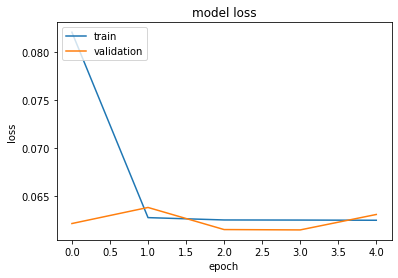

In [47]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#plt.savefig('Model loss.jpg')



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


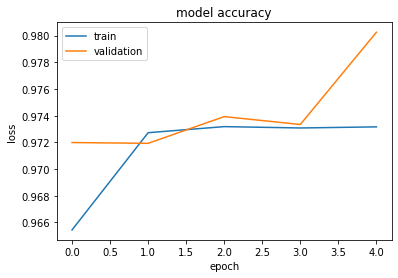

In [48]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#plt.savefig('Model Accuracy.jpg')

In [49]:
yTestPredicted = model.predict(xTest,verbose=1)
yTestPredicted = yTestPredicted[:,1]

24938/24938 [==============================] - 29s 1ms/step


In [50]:
yTestPredicted = (yTestPredicted>0.95).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)
print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))


Confusion matrix: for 14 nodes
 [[699764   2016]
 [ 37914  58306]]

P-Score: 0.967, R-Score: 0.606


In [94]:
predicted = model.predict(featuresTest,verbose =1)
predicted = predicted[:,1]

22931/22931 [==============================] - 26s 1ms/step


(-0.5, 830.5, 882.5, -0.5)

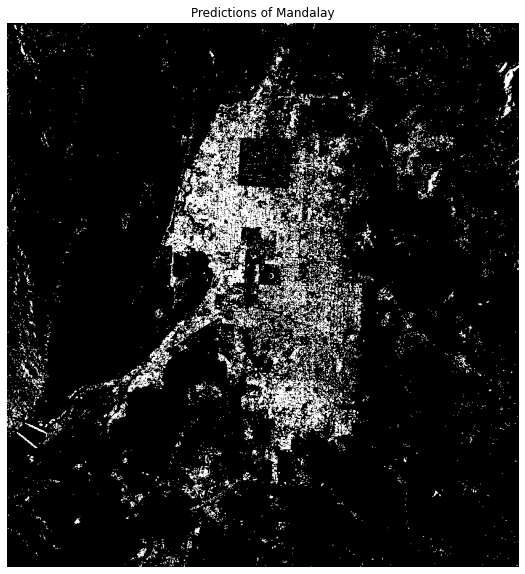

In [95]:
prediction = np.reshape(predicted, (ds3.RasterYSize, ds3.RasterXSize))
preds = prediction<=0.9
plt.figure(figsize=(10,10))
plt.imshow(preds,cmap='Greys')
plt.title('Predictions of Mandalay')
plt.axis('off')
#outFile = 'Test_BuiltupNN_predicted.tif' # uncomment this if you want to download geotif image
#raster.export(preds, ds3, filename=outFile, dtype='float') #uncomment this for downloading geotif image



## Model saving

In [59]:
model.save('/content/builduparea_detection_version1.h5') 

# For inferencing new area, the following codes can be used

## Preprocessing Image and Prediction module

In [83]:
def preprocess_image(mxTesting):
  """
  arguments : mxTesting is inferencing image
  """
  ds3, featuresTest = raster.read(mxTesting, bands='all')
  featuresTest = changeDimension(featuresTest)
  featuresTest = featuresTest / 255.0
  featuresTest = featuresTest.reshape((featuresTest.shape[0], 1, featuresTest.shape[1]))
  return featuresTest

In [106]:
def prediction(model,featuresTest):
  class_model =keras.models.load_model('/content/builduparea_detection_version1.h5')
  classification =class_model.predict(featuresTest,verbose=1)
  classification = classification[:,1]
  prediction_data = np.reshape(classification, (ds3.RasterYSize, ds3.RasterXSize))
  preds = prediction_data<=0.95
  #plt.imshow(preds)
  #plt.colorbar()
  
  return (preds)

# Load your input image in preprocess_image() function

In [96]:
preprocess_data =preprocess_image('/content/new_s1_median_mdy.tif')

# Viewing the inferenced Image

22931/22931 [==============================] - 26s 1ms/step


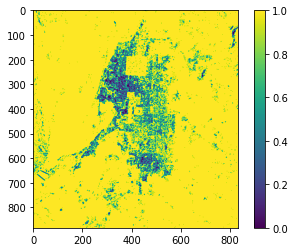

In [108]:
plt.imshow(prediction('/content/builduparea_detection_version1.h5',preprocess_data))